# Analysis and Visualization of the cleaned Dataset

### Overview

This notebook contains the analysis of the cleaned CSV dataset of the JetBrains Survey. 


### Prerequisites

Before running this notebook, you would need to export your excel files. You can do this with these steps:
- Open the current directory in your terminal
- Create a virtual environment via: `pipenv shell`
- Install all the app dependencies via: `pipenv install`
- Export a tidy excel file with the command: `python cli.py tidy-and-export --output_filename cleaned_dataset.xlsx`

Alternatively, you can run the commands in the cells below:

In [ ]:
# First we install the dependencies that the script requires to run
!pip install click pandas numpy python-dotenv

!EXPORT_FILENAME='cleaned_dataset.xlsx' 
# Then we execute the script python cli.py tidy-and-export --output_filename [put-your-filename-here]
!python cli.py tidy-and-export --output_filename $EXPORT_FILENAME


In [505]:
# import all modules needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import math
# Declaring some constants
CLEAN_EXCEL_FILENAME='cleaned_dataset.xlsx'  
QUESTION_STR_DICT = {}

### Read Excel file

In the following cells we read the excel file into a variable `CLEAN_EXCEL_DATA`

In [551]:

EXCEL_FILE_DATA = pd.ExcelFile(CLEAN_EXCEL_FILENAME)


In [552]:
def covert_excel_file_to_dataframe(excel_file_data):
    clean_questions_dict = {}
    question_str_dict= {}
    for q_name in excel_file_data.sheet_names:
        question_df = excel_file_data.parse(q_name, index_col=0)
        question_str = question_df.iloc[0,0]
        del question_df['question']
        clean_questions_dict[q_name] ={
            'str': question_str,
            'dataframe': question_df
        } 
        
    return clean_questions_dict


In [553]:
CLEAN_QUESTIONS_DICT = covert_excel_file_to_dataframe(EXCEL_FILE_DATA)

#### Question 1 Analysis
Now that we have put all the sheet data in `CLEAN_QUESTIONS_DICT` with question number as key and the question name as value, we can start processing each question by performing EDAs on them first.


In [554]:
# Question 1
question_1 = CLEAN_QUESTIONS_DICT['Question 1']
question_1_df = question_1['dataframe']
question_1_df.iloc[:,0].value_counts()


Yes                                               15404
No, I use Python as a secondary language           3027
No, I don’t use Python for my current projects     1404
Name: answer_chosen, dtype: int64

In [555]:
def plot_pie_chart(x_col, labels_col,df, title='', title_loc='right', legend_loc=None):
    _ = plt.style.use('seaborn-darkgrid')
    _ = plt.pie(df[x_col], labels=df[labels_col], autopct='%.2f%%', textprops={'color':'w'})
    _ = plt.tight_layout()
    plt.legend(loc=legend_loc)
    plt.title(title, loc=title_loc)

In [556]:

question_1_df['count'] = 1
grouped_question_1 = question_1_df.groupby('answer_chosen').count()
grouped_question_1['percentage'] = 100* (grouped_question_1['count']/ grouped_question_1['count'].sum())
grouped_question_1 = grouped_question_1.reset_index()



In [557]:
grouped_question_1 = grouped_question_1.replace(
    'No, I don’t use Python for my current projects', 'Not a Pythoner'
)
grouped_question_1 = grouped_question_1.replace(
    'No, I use Python as a secondary language', 'Python is Secondary'
)
grouped_question_1 = grouped_question_1.replace('Yes', 'Python is Main')


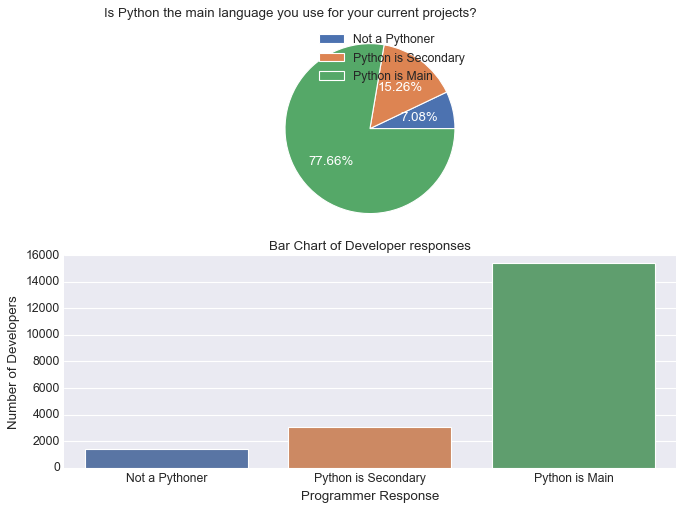

In [558]:

sns.set()
plt.subplot(2,1,1)
plot_pie_chart('count', 'answer_chosen', grouped_question_1, question_1['str'])
plt.subplot(2,1,2)

sns.set(style="darkgrid")
_ = sns.barplot(x="answer_chosen", y="count", data=grouped_question_1, errwidth=20)


plt.title('Bar Chart of Developer responses')
plt.xlabel('Programmer Response')
plt.ylabel('Number of Developers')
plt.show()



In [562]:
question_42_df = CLEAN_QUESTIONS_DICT['Question 42']['dataframe'].sort_index()


In [644]:
# Link between python and country of origin

question_1_with_country = pd.merge(question_1_df, question_42_df, left_index=True, right_index=True)
del question_1_with_country['count']

question_1_with_country.columns = ['Python Usage', 'Country']
question_1_with_country['count'] = 1
question_1_with_country = question_1_with_country.replace(
    'No, I don’t use Python for my current projects', 'Not a Pythoner'
)
question_1_with_country = question_1_with_country.replace(
    'No, I use Python as a secondary language', 'Python is secondary'
)

question_1_with_country = question_1_with_country.replace('Yes', 'Python is Main')

question_1_with_country['percentage'] = \
    question_1_with_country['count'] / question_1_with_country['count'].sum()

question_1_with_country = question_1_with_country.groupby(['Python Usage', 'Country']).sum()


question_1_with_country = question_1_with_country.reset_index()

In [621]:
def plot_bar_chart(x_col,y_col,data, hue=None,bar_title='' ,
                   show_x_axis=True, legend_loc='upper left',
                  x_label_angle=90):
    """Plots a bar chart to the notebook with the argument
    
    
    Args:
        x_col(str): a string specifying the x column of the bar chart
        y_col(str): a string specifying the y axis of the bar chart
        data(pd.Dataframe): a dataframe containing the data
        hue(str): optional argument defaults to None. It is used to control the 
        number of bars in each y_col
        bar_title(str): the title of the bar chart
        
    """
    _ = sns.set(style="darkgrid")
    barplot_obj = sns.barplot(x=x_col, y=y_col, data=data, hue=hue)
    plt.title(bar_title)
    barplot_obj.axes.get_xaxis().set_visible(show_x_axis)
    plt.xlabel('')
    barplot_obj.set_xticklabels(data[x_col].unique(),rotation=x_label_angle)
    plt.legend(loc=legend_loc)
    plt.show()

def show_chart_for_countries(countries, bar_title,data=question_1_with_country):
    
    countries = data[data['Country'].isin(countries)]
    
    plot_bar_chart("Python Usage","count", countries, hue='Country', bar_title=bar_title, x_label_angle=0)
    
    

With the function above, we can display charts that compare the responses of several countries. Let us start by showing african countries

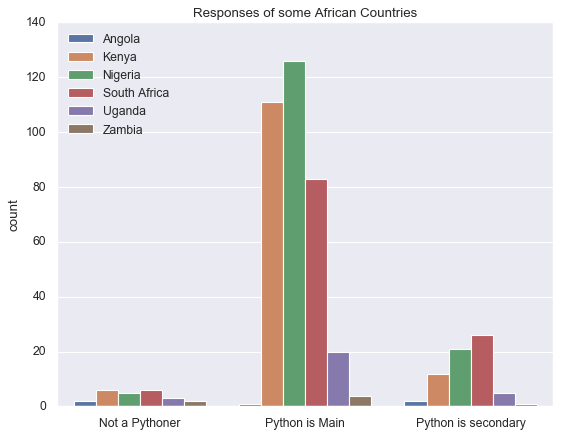

In [622]:
african_countries_list = ['Angola', 'Zambia', 'Nigeria', 'Kenya','Uganda', 'South Africa']
show_chart_for_countries(african_countries_list, 'Responses of some African Countries', data=question_1_with_country)


**There seem to be more `Nigerians` in the python game than any other African country**

Next we display the patterns for some North American countries

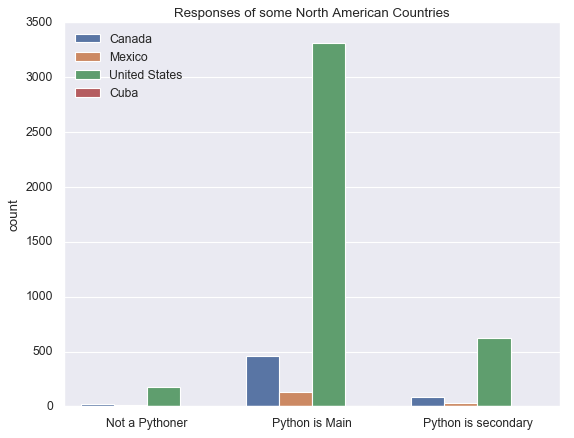

In [623]:
north_america = ['United States', 'Mexico', 'Canada','Cuba']
show_chart_for_countries(north_america, 'Responses of some North American Countries')


As expected the US Dominates North America. Lets see how the big boys of Europe and Asia are lloking

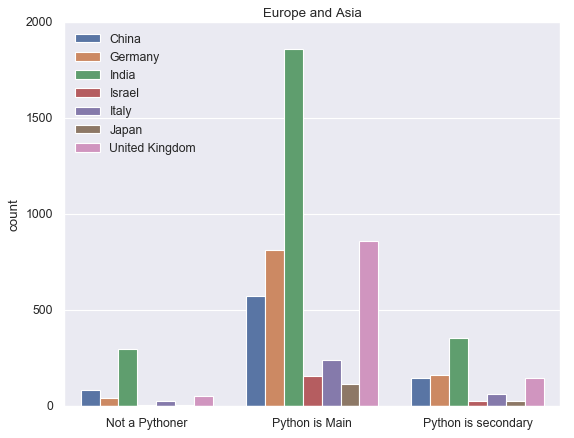

In [647]:
europe_and_asia = ['Germany','China','Japan', 'India','Italy', 'Israel', 'United Kingdom']
show_chart_for_countries(europe_and_asia, 'Europe and Asia')


Let us Recreate the charts based on quatiles


In [648]:
def plot_coutries_within_percentile(percentile,title, above=True):
    
    countries_with_yes = question_1_with_country[question_1_with_country['Python Usage'] == 'Python is Main']

    val = countries_with_yes['count'].quantile([percentile])
    count_filter =question_1_with_country['count']> int(val) if above else question_1_with_country['count']<= int(val) 

    top_countries = question_1_with_country[
       count_filter & (question_1_with_country['Python Usage'] == 'Python is Main')
    ]
    show_chart_for_countries(top_countries['Country'].values, title)


In [649]:
question_1_with_country['Python Usage'].unique()


array(['Not a Pythoner', 'Python is Main', 'Python is secondary'],
      dtype=object)

In [650]:
question_1_with_country[question_1_with_country['Country'] == 'United States']


,Python Usage,Country,count,percentage
121,Not a Pythoner,United States,179,0.009024
274,Python is Main,United States,3313,0.167028
391,Python is secondary,United States,624,0.031460


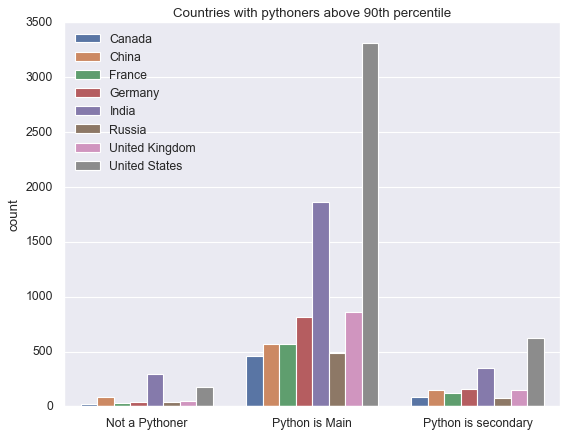

In [651]:
plot_coutries_within_percentile(0.95, 'Countries with pythoners above 90th percentile')

#### Question 2 Analysis and visualisation

Now, let us look at the second question 
> What other language(s) do you use?

It  was asked to only python uses 


18431

In [746]:
question_2_df = CLEAN_QUESTIONS_DICT['Question 2']['dataframe']
question_str = CLEAN_QUESTIONS_DICT['Question 2']['str']
question_2_df['count'] = 1

question_2_df['answer_chosen'] = question_2_df['answer_chosen'].replace('Visual Basic', 'VB')
question_2_df['answer_chosen'] = question_2_df['answer_chosen'].replace('Bash / Shell', 'Bash')
question_2_df['answer_chosen'] = question_2_df['answer_chosen'].replace('Other - Write In:', 'Other')
question_2_df['answer_chosen'] = question_2_df['answer_chosen'].replace('JavaScript', 'JS')

unique_index_num = len(question_2_df.index.unique())

sorted_question_2 = question_2_df.reset_index().groupby([ 'answer_chosen']).sum()
del sorted_question_2['index']
sorted_question_2['percentage'] = 100 * (chosen_sum['count'] / unique_index_num)
sorted_question_2 = chosen_sum.sort_values('percentage', ascending=False).reset_index()

#### Chart of Others languages used by python developers

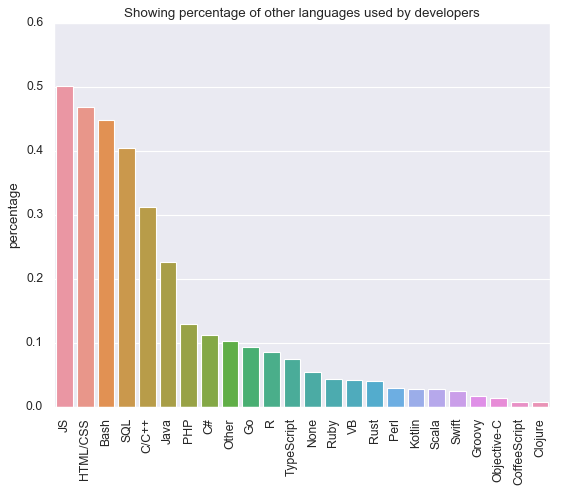

In [747]:
# Showing all chart of Other languages used by developers
chart_title = 'Showing percentage of other languages used by developers'
plot_bar_chart(
    'answer_chosen', 'percentage', sorted_question_2, 
    bar_title=chart_title,  legend_loc=None
)


> The chart above reveals that about 50% of the python developers said they also used `Javascript` with `HTML` and `Bash` coming after it 

#### Zooming in on the top 10

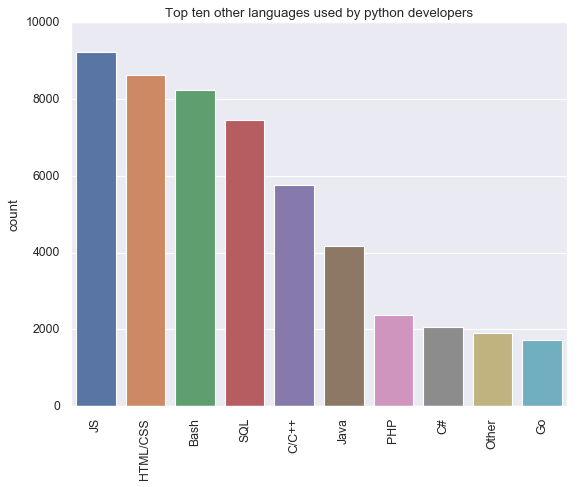

In [748]:
top_10_replies = sorted_question_2.iloc[0:10,:]

chart_title = 'Top ten other languages used by python developers'
plot_bar_chart(
    'answer_chosen', 'count', top_10_replies, 
    bar_title=chart_title,  legend_loc=None
)



#### Zooming in on the last 10

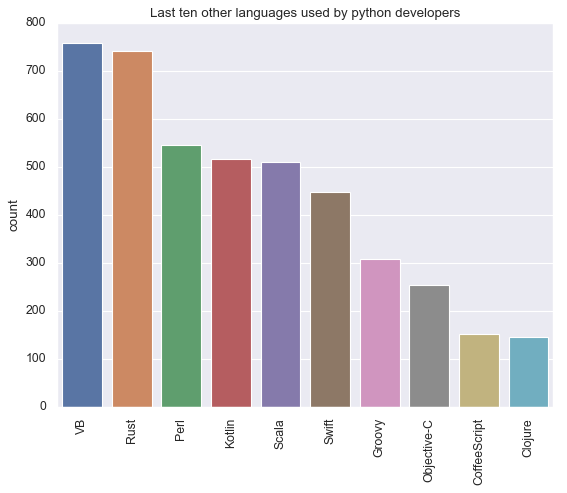

In [752]:

last_10_replies = sorted_question_2.iloc[-10:,:]

chart_title = 'Last ten other languages used by python developers'
plot_bar_chart(
    'answer_chosen', 'count', last_10_replies, 
    bar_title=chart_title,  legend_loc=None
)